<a href="https://colab.research.google.com/github/NikTamu3/myproject/blob/main/MY_US_UNET_MOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import tensorflow as tf
import keras

In [ ]:
data=tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/datasets',batch_size=32)

Found 692 files belonging to 4 classes.


In [ ]:
import os

dataset_path = '/content/drive/MyDrive/datasets'

categories = ['strictured_data', 'non_strictured']

total_images = 0
total_masks = 0

for category in categories:
    images_path = os.path.join(dataset_path, category)
    masks_path = os.path.join(dataset_path, f"{category}_mask")

    images_count = len(os.listdir(images_path))
    masks_count = len(os.listdir(masks_path))

    total_images += images_count
    total_masks += masks_count

    print(f"Total {category.capitalize()} Data:", images_count)

print("Total Images:", total_images)
print("Total Masks:", total_masks)




Total Strictured_data Data: 168
Total Non_strictured Data: 178
Total Images: 346
Total Masks: 346


In [ ]:
import os
import cv2
import numpy as np

dataset_path = '/content/drive/MyDrive/datasets'
image_folders = ['non_strictured', 'strictured_data']
mask_folders = ['non_strictured_mask', 'strictured_data_mask']

X_train = []
Y_train = []

for image_folder, mask_folder in zip(image_folders, mask_folders):
    image_files = os.listdir(os.path.join(dataset_path, image_folder))
    mask_files = os.listdir(os.path.join(dataset_path, mask_folder))

    for image_file in image_files:
        mask_file = image_file.replace('.bmp', 'Mask.bmp')
        if mask_file in mask_files:
            image_path = os.path.join(dataset_path, image_folder, image_file)
            mask_path = os.path.join(dataset_path, mask_folder, mask_file)

            image = cv2.imread(image_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)


            image = cv2.resize(image, (256, 256))
            mask = cv2.resize(mask, (256, 256))

            X_train.append(image)
            Y_train.append(mask)

X_train = np.array(X_train)
Y_train = np.array(Y_train)


X_train = X_train.astype('float32') / 255.0


Y_train = Y_train.reshape(-1, 256, 256, 1)
Y_train = Y_train.astype('float32') / 255.0

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)


X_train shape: (346, 256, 256, 3)
Y_train shape: (346, 256, 256, 1)


In [ ]:
# Checking max and min values for images and masks
print("Max pixel value for images:", X_train.max())
print("Min pixel value for images:", X_train.min())
print("Max pixel value for masks:", Y_train.max())
print("Min pixel value for masks:", Y_train.min())

Max pixel value for images: 1.0
Min pixel value for images: 0.0
Max pixel value for masks: 1.0
Min pixel value for masks: 0.0


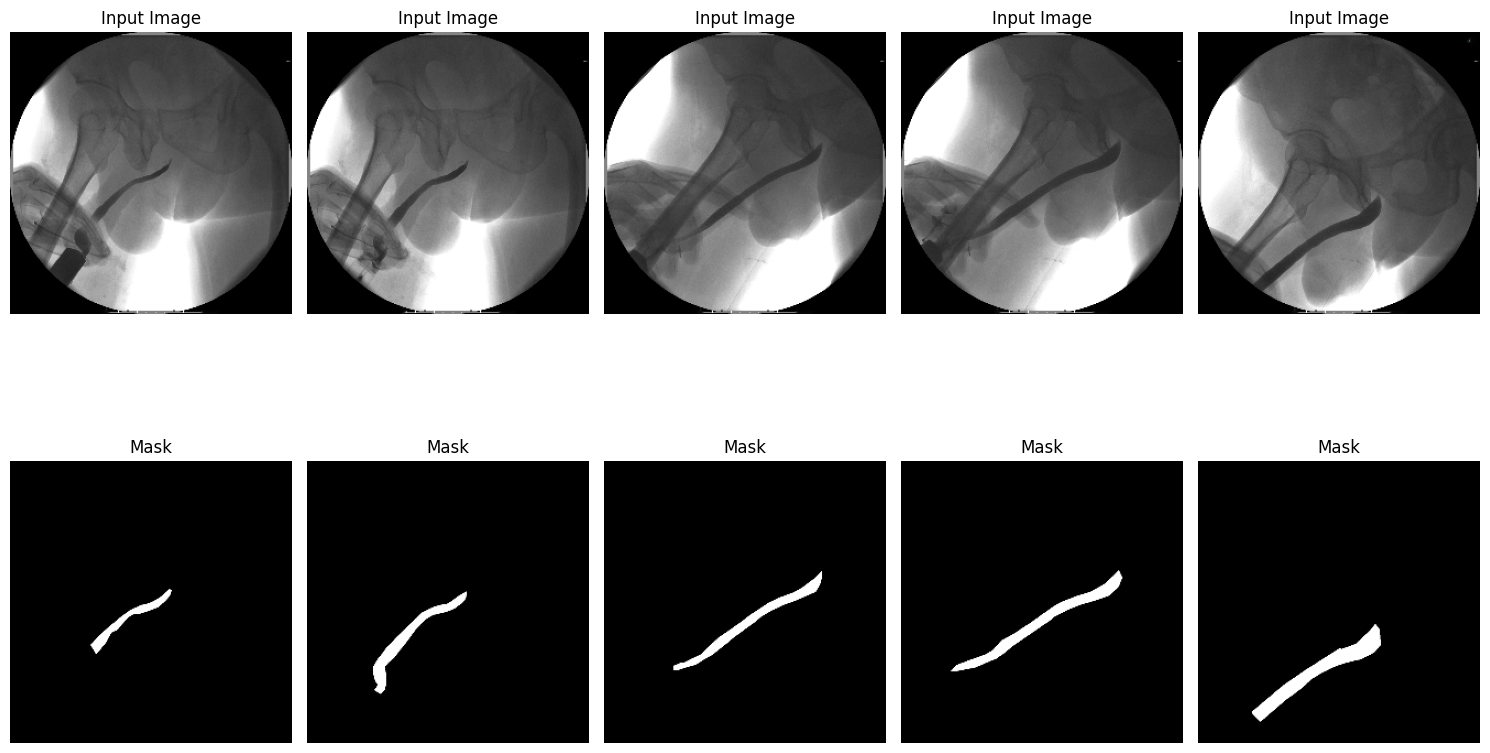

In [ ]:
import matplotlib.pyplot as plt


combined_images = list(zip(X_train, Y_train))

# Plot the first few images and masks
num_images = 5
plt.figure(figsize=(15, 10))
for i in range(num_images):
    # Plotting input image
    plt.subplot(2, num_images, i + 1)
    plt.imshow(combined_images[i][0])
    plt.axis('off')
    plt.title('Input Image')

    # mask
    plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(combined_images[i][1].reshape(256, 256), cmap='gray')
    plt.axis('off')
    plt.title('Mask')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the data into training (70%), validation (20%), and testing (10%) sets
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.22, random_state=42)

print("Training set shapes:", X_train.shape,Y_train.shape)
print("Validation set shapes:", X_val.shape, Y_val.shape)
print("Testing set shapes:", X_test.shape, Y_test.shape)



Training set shapes: (242, 256, 256, 3) (242, 256, 256, 1)
Validation set shapes: (69, 256, 256, 3) (69, 256, 256, 1)
Testing set shapes: (35, 256, 256, 3) (35, 256, 256, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

def dice_coefficient(y_true, y_pred):
    smooth = 1e-15
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def iou(y_true, y_pred):
    smooth = 1e-5
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred))
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def iou_loss(y_true, y_pred):
    return -iou(y_true, y_pred)


class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.best_iou = -1
        self.best_dice = -1
        self.best_recall = -1
        self.best_precision = -1

    def on_epoch_end(self, epoch, logs=None):
        X_val, Y_val = self.validation_data
        y_pred = self.model.predict(X_val)
        iou_val = iou(Y_val, y_pred)
        dice_val = dice_coefficient(Y_val, y_pred)
        recall_val = Recall()(Y_val, y_pred)
        precision_val = Precision()(Y_val, y_pred)



        if dice_val > self.best_dice:
            self.best_dice = dice_val
            self.model.save('USUNET_model.h5')

        # if recall_val > self.best_recall:
        #     self.best_recall = recall_val
        #     self.model.save('best_recall_model.h5')

        # if precision_val > self.best_precision:
        #     self.best_precision = precision_val
        #     self.model.save('best_precision_model.h5')

        print(f'\nEpoch {epoch + 1} - IoU: {iou_val}, Dice: {dice_val}, Recall: {recall_val}, Precision: {precision_val}')

# Callbacks
callbacks = [
    ModelCheckpoint('US_UNET_model.h5', monitor='val_loss', mode='min', save_best_only=True),
    TensorBoard(log_dir='USUNET_logs', histogram_freq=0, write_graph=True, write_images=False),
    MetricsCallback((X_val, Y_val))

]


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, BatchNormalization, Conv2DTranspose
from tensorflow.keras.optimizers import Adam

inputs = Input((256,256,3))


#Contraction path
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = BatchNormalization()(c1)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = BatchNormalization()(c5)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = BatchNormalization()(c6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = BatchNormalization()(c7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = BatchNormalization()(c8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = BatchNormalization()(c9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = Model(inputs=[inputs], outputs=[outputs])

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_57 (Conv2D)          (None, 256, 256, 16)         448       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_39 (Ba  (None, 256, 256, 16)         64        ['conv2d_57[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 dropout_27 (Dropout)        (None, 256, 256, 16)         0         ['batch_normalization_39

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=iou_loss, metrics=['accuracy',dice_coefficient,iou,Precision(),Recall()])


In [ ]:
history = model.fit(X_train,Y_train, validation_data=(X_val, Y_val), batch_size=32, epochs=150,callbacks=callbacks)

In [ ]:
# model on the test set
loss = model.evaluate(X_test, Y_test)
print("Test Loss:", loss)


2/2 [==============================] - 0s 26ms/step - loss: -0.7842 - accuracy: 0.9947 - dice_coefficient: 0.8717 - iou: 0.7726 - precision_1: 0.8845 - recall_1: 0.8758
Test Loss: [-0.7841996550559998, 0.9947060942649841, 0.8716652989387512, 0.7726336121559143, 0.8845203518867493, 0.8757619261741638]


In [ ]:
model.save('USUNET_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


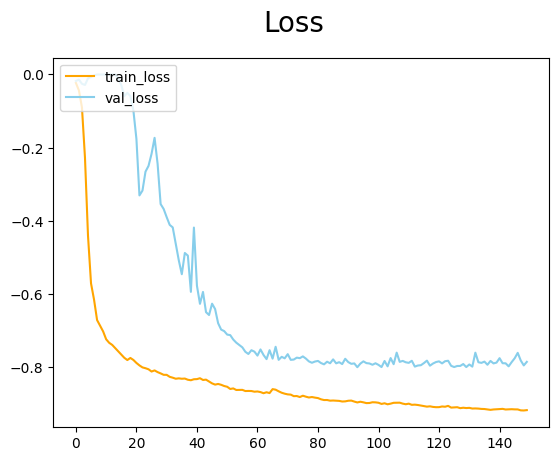

In [ ]:
fig=plt.figure()
plt.plot(history.history['loss'],color='orange',label='train_loss')
plt.plot(history.history['val_loss'],color='skyblue',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc='upper left')
plt.show()

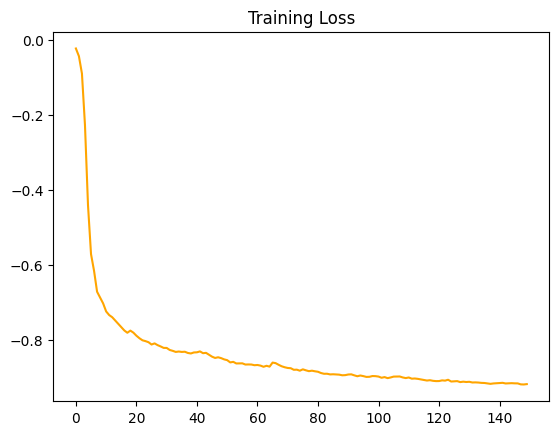

In [ ]:
plt.plot(history.history['loss'],color='orange')
plt.title('Training Loss')
plt.show()

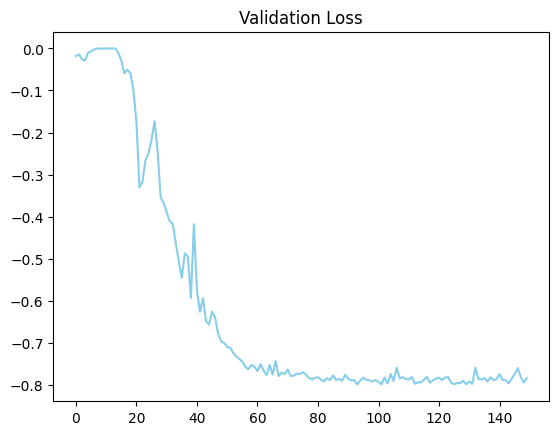

In [ ]:
plt.plot(history.history['val_loss'],color='skyblue')
plt.title('Validation Loss')
plt.show()

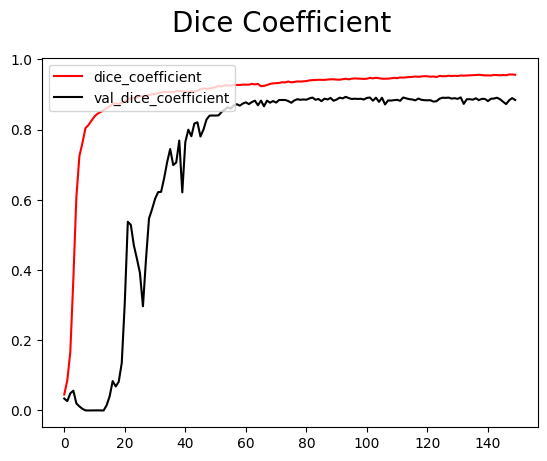

In [ ]:
fig=plt.figure()
plt.plot(history.history['dice_coefficient'],color='red',label='dice_coefficient')
plt.plot(history.history['val_dice_coefficient'],color='black',label='val_dice_coefficient')
fig.suptitle('Dice Coefficient',fontsize=20)
plt.legend(loc='upper left')
plt.show()

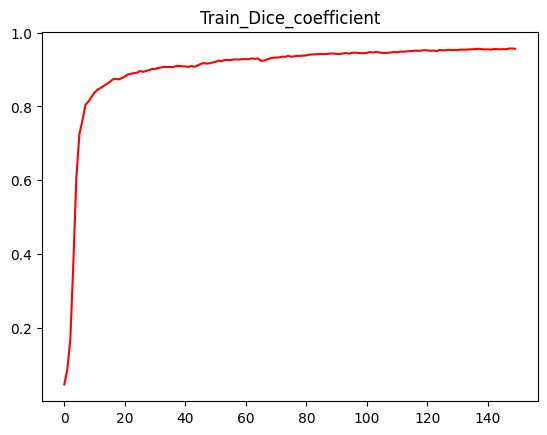

In [ ]:
plt.plot(history.history['dice_coefficient'],color='red')
plt.title('Train_Dice_coefficient')
plt.show()

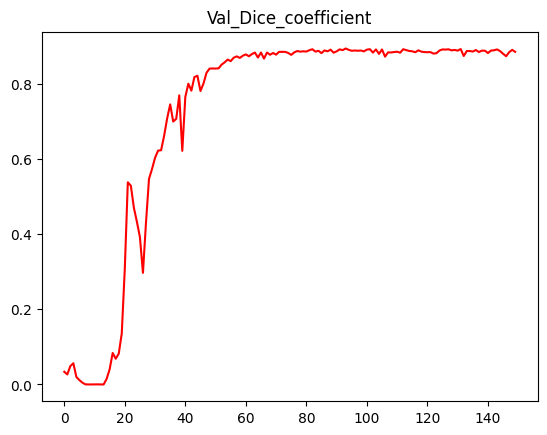

In [ ]:
plt.plot(history.history['val_dice_coefficient'],color='red')
plt.title('Val_Dice_coefficient')
plt.show()

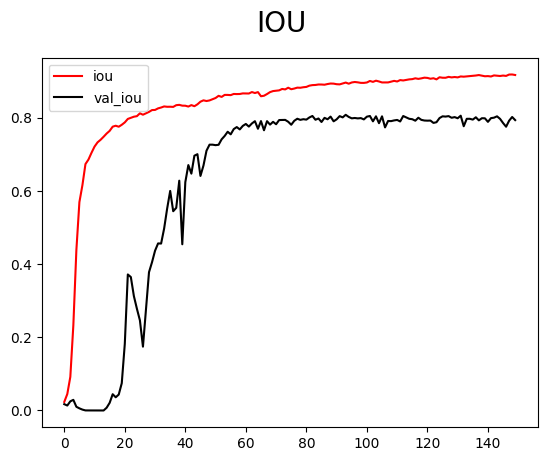

In [ ]:
fig=plt.figure()
plt.plot(history.history['iou'],color='red',label='iou')
plt.plot(history.history['val_iou'],color='black',label='val_iou')
fig.suptitle('IOU',fontsize=20)
plt.legend(loc='upper left')
plt.show()

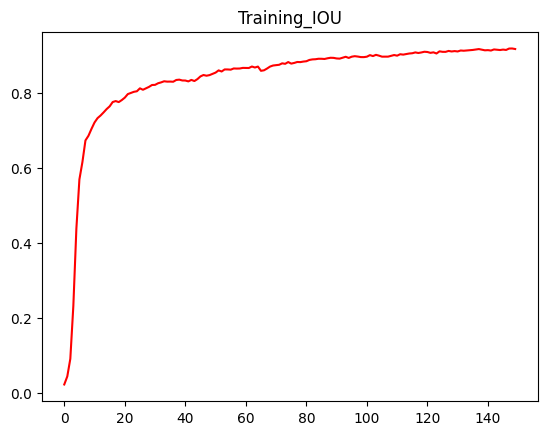

In [ ]:
plt.plot(history.history['iou'],color='red')
plt.title('Training_IOU')
plt.show()

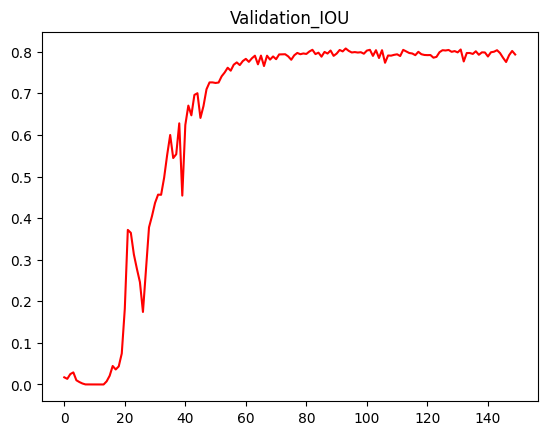

In [ ]:
plt.plot(history.history['val_iou'],color='red')
plt.title('Validation_IOU')
plt.show()

In [ ]:
# Iterating over all images in the validation set
for i in range(len(X_val)):

    image = X_val[i:i+1]
    mask_true = Y_val[i].reshape(1, 256, 256, 1)
    mask_pred = model.predict(image)


    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(image[0])
    plt.axis('off')
    plt.title('Input Image')

    plt.subplot(1, 3, 2)
    plt.imshow(mask_true[0, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.title('Ground Truth Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(mask_pred[0, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.title('Predicted Mask')

    plt.tight_layout()
    plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

def iou(y_true, y_pred):
    smooth = 1e-5
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred))
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def iou_loss(y_true,y_pred):
  return -iou(y_true,y_pred)

# Defining the custom metric function
def dice_coefficient(y_true, y_pred):
    smooth = 1e-15
    intersection = K.sum(y_true * y_pred)
    return (2.0 * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

model = load_model('/content/drive/MyDrive/unet_model/USS_UNET_MODEL.h5', custom_objects={'iou_loss': iou_loss, 'dice_coefficient': dice_coefficient,'iou':iou})




In [ ]:
predictions = model.predict(X_test)

2/2 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 21ms/step


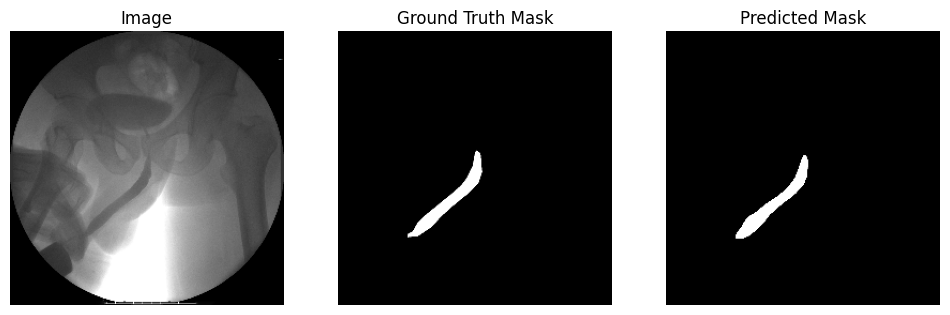

1/1 [==============================] - 0s 26ms/step


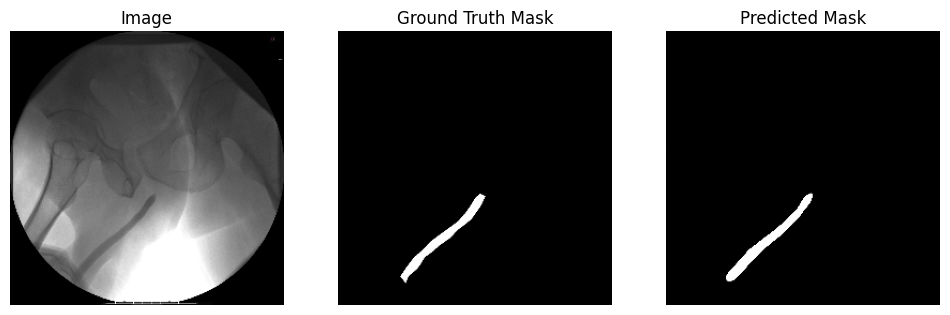

1/1 [==============================] - 0s 20ms/step


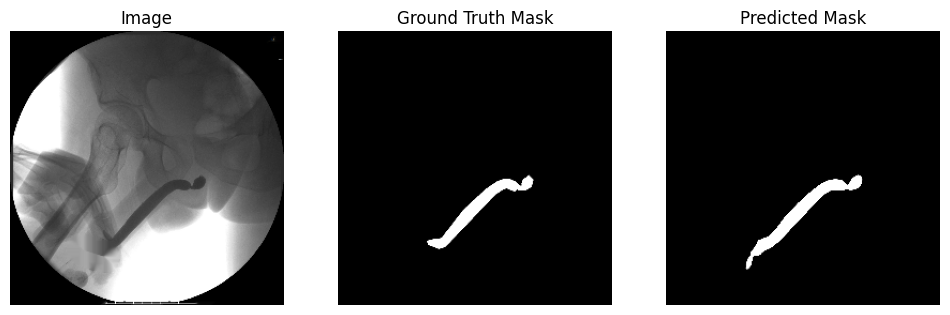

1/1 [==============================] - 0s 25ms/step


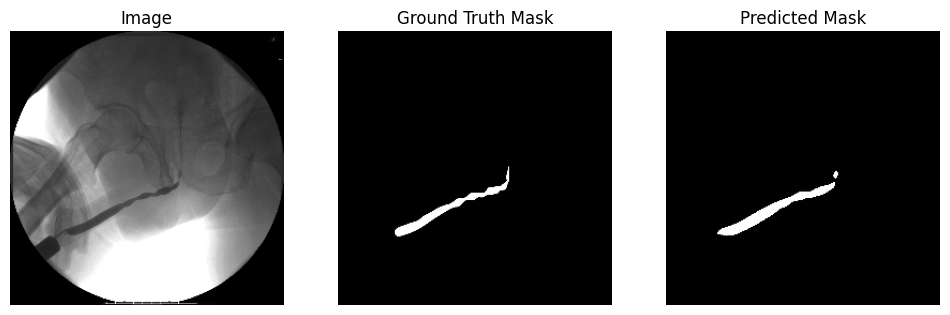

1/1 [==============================] - 0s 20ms/step


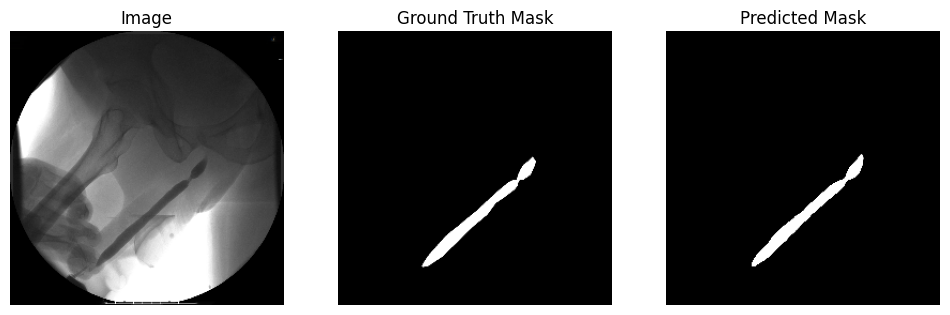

In [ ]:
import matplotlib.pyplot as plt


num_images_to_visualize = 5
for i in range(num_images_to_visualize):

    image = X_test[i]
    mask = Y_test[i]


    prediction =model.predict(image.reshape(1, 256, 256, 3))[0]

    # Plotting the image, ground truth mask, and predicted mask
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask.reshape(256, 256), cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(prediction.reshape(256, 256), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()


In [ ]:
def dice_coefficient(y_true, y_pred):
    smooth = 1e-15
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def iou(y_true, y_pred):
    smooth = 1e-5
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred))
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def iou_loss(y_true, y_pred):
    return -iou(y_true, y_pred)

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('/content/drive/MyDrive/MY_US_PROJECT/UNET/USS_UNET_MODEL.h5', custom_objects={'iou_loss': iou_loss, 'dice_coefficient': dice_coefficient,'iou':iou})

# Evaluate the model on the validation data
val_loss, val_accuracy, val_dice_coefficient, val_iou, val_precision, val_recall = loaded_model.evaluate(X_val, Y_val)

print(f'Validation Dice Coefficient: {val_dice_coefficient}')


In [ ]:
def dice_coefficient(y_true, y_pred):
    smooth = 1e-15
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def iou(y_true, y_pred):
    smooth = 1e-5
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred))
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def iou_loss(y_true, y_pred):
    return -iou(y_true, y_pred)

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model('/content/drive/MyDrive/MY_US_PROJECT/UNET/USS_UNET_MODEL.h5', custom_objects={'iou_loss': iou_loss, 'dice_coefficient': dice_coefficient,'iou':iou})


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
new_image_path = '/content/drive/MyDrive/datasets/strictured_data/cdata102.bmp'
new_image = cv2.imread(new_image_path)
new_image = cv2.resize(new_image, (256, 256))
new_image = np.expand_dims(new_image, axis=0)
new_image = new_image / 255.0


1/1 [==============================] - 0s 158ms/step


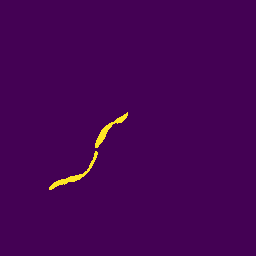

In [ ]:
prediction = loaded_model.predict(new_image)


threshold = 0.5
binary_mask = (prediction > threshold).astype(np.uint8)

binary_mask = cv2.resize(binary_mask[0], (new_image.shape[1], new_image.shape[2]))

colormap_mask = cv2.applyColorMap((binary_mask * 255).astype(np.uint8), cv2.COLORMAP_VIRIDIS)


masked_image =colormap_mask
from google.colab.patches import cv2_imshow
cv2_imshow(masked_image)
